<a href="https://colab.research.google.com/github/droyktton/ALM-pbc-ground-state/blob/main/NuevoALM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumary of Results

* Exact parallel algorithm for the ground state which is more efficient than Dijkstra.

* Spectral exponent $\zeta_s$ vs anharmonicity index $n$, $\zeta_s - \zeta$ is not constant, but has little non-trivial variation...

* Finite size scaling confirms anomalous scaling.

#Exact Numerical Construction of the Ground State (1D)

We consider a one–dimensional elastic interface with quenched disorder,
described by the Hamiltonian
\begin{equation}
\mathcal H[u] =
\sum_{i=0}^{L-1}
\left[
\frac{c}{2}\,(u_{i+1}-u_i)^2
+ \frac{1}{2n}\,|u_{i+1}-u_i|^{2n}
- f_i\,u_i
\right],
\qquad n \ge 1 ,
\end{equation}
with periodic boundary conditions. The disorder forces $f_i$
 are
independent Gaussian variables,
\begin{equation}
f_i \sim \mathcal N(0,\Delta).
\end{equation}

Define the local slope
\begin{equation}
s_i = u_{i+1} - u_i .
\end{equation}

## Equilibrium condition

At zero temperature, minimization of $\mathcal H$ yields
\begin{equation}
c\, s_i + |s_i|^{2n-1}\,\mathrm{sign}(s_i) = \sigma_i ,
\end{equation}
where the stress field $\sigma_i$ is the cumulative sum of the disorder,
\begin{equation}
\sigma_i = \sum_{j=0}^{i-1} f_j + C .
\end{equation}
The constant $C$ is a Lagrange multiplier enforcing periodicity.

**There is a unique solution of this equation**
At variance with uncorrelated quenched disorder, for the random force there is *no metastability*, but there is roughness.   

## Local constitutive inversion

For each site $i$, the slope is obtained by inverting the constitutive law,
\begin{equation}
s_i = g(\sigma_i),
\end{equation}
where $g$ is the unique solution of
\begin{equation}
c\, s + |s|^{2n-1}\,\mathrm{sign}(s) = \sigma .
\end{equation}

*Pure nonlinear elasticity ($c=0$)*

The inversion is analytic:
\begin{equation}
s_i =
\mathrm{sign}(\sigma_i)\,
|\sigma_i|^{\frac{1}{2n-1}} .
\end{equation}

*Harmonic + nonlinear elasticity ($c>0$)*

The inversion is performed locally by a scalar root solve; uniqueness and
stability are guaranteed by convexity.

## Global constraint

Periodic boundary conditions require zero total slope,
\begin{equation}
\sum_{i=0}^{L-1} s_i(C) = 0 .
\end{equation}
Since $s_i(C)$ is a strictly monotonic function of $C$, this condition is
enforced by a one–dimensional root finding procedure.

## Reconstruction of the displacement

Once $C$ is fixed, the displacement field is reconstructed by summation,
\begin{equation}
u_{i+1} = u_i + s_i ,
\end{equation}
with an arbitrary additive constant (e.g. $\sum_i u_i = 0$).

## Properties

* The algorithm yields the exact $T=0$ ground state.
* Computational cost scales linearly with system size $L$.
* Disorder enters only through a prefix sum.
* High-dimensional minimization reduces to a scalar constraint.


## Scaling of slopes and interface (global) roughness

The scaling of the displacement field follows from the constitutive relation
that maps stress to slope. Since the typical stress on length scale $\ell$
scales as
$$
\sigma(\ell) \sim \ell^{1/2},
$$
the scaling of the local slope depends on the dominant elastic term.

### Pure nonlinear elasticity ($c=0$)

For $c=0$, the constitutive law reads
$$
s \sim |\sigma|^{1/(2n-1)} .
$$
Therefore,
$$
s(\ell) \sim \ell^{\frac{1}{2(2n-1)}} .
$$
The displacement over a distance $\ell$ is obtained by summing the slopes,
$$
u(\ell) \sim \int_0^\ell s(x)\,dx
\sim \ell^{1+\frac{1}{2(2n-1)}} .
$$
This defines the roughness exponent $\zeta$ via
$$
u(\ell) \sim \ell^{\zeta},
$$
yielding
$$
\boxed{
\zeta = 1 + \frac{1}{2(2n-1)}
}
$$
for pure nonlinear elasticity.

### Harmonic elasticity at small scales ($c>0$)

When $c>0$, small stresses satisfy $s \approx \sigma / c$, so that
$$
s(\ell) \sim \ell^{1/2},
\qquad
u(\ell) \sim \ell^{3/2}.
$$
Thus, on sufficiently small length scales, the interface exhibits harmonic
elastic roughness with exponent
$$
\zeta_{\mathrm{harm}} = \frac{3}{2}.
$$

which is just the usual Larkin exponent $\zeta_{\mathrm{harm}} = (4-d)/2$.

### Crossover and large-scale behavior

At larger scales, stress fluctuations grow until the nonlinear term dominates.
The crossover occurs when
$$
c\,s \sim |s|^{2n-1},
$$
which defines a characteristic slope
$$
s_\times \sim c^{-1/(2n-2)} .
$$
The corresponding crossover length $\ell_\times$ follows from
$$
s(\ell_\times) \sim s_\times,
$$
giving
$$
\ell_\times \sim c^{-\frac{2(2n-1)}{2n-2}} .
$$
For $\ell \gg \ell_\times$, the system crosses over to the nonlinear scaling
regime with roughness exponent
$$
\zeta = 1 + \frac{1}{2(2n-1)} .
$$

## Interpretation

The roughness of the interface is entirely controlled by the statistics of the
integrated disorder and the local constitutive law. Harmonic elasticity does not
change the asymptotic universality class, but introduces a finite crossover
scale below which the interface appears harmonic.

This is in perfect agreement with [our previous article](https://arxiv.org/abs/1812.10435).

The interesting part is that there is also an spectral exponent $\zeta_s \neq \zeta$ which seems to be produced by the *average tilt constraint*...


# CUDA code

In [1]:
%%writefile alm.cu

#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/transform.h>
#include <thrust/transform_reduce.h>
#include <thrust/scan.h>
#include <thrust/reduce.h>
#include <thrust/random.h>
#include <thrust/functional.h>
#include <cmath>
#include <iostream>
#include <fstream>

#ifndef ANHN
#define ANHN 2
#endif

#ifndef SIZEL
#define SIZEL 1024
#endif

typedef double real;

const int L = SIZEL;
const real Delta = 1.0f;
const real n = ANHN;
const real c = 0.0f;   // set c=0 for closed form

// -----------------------------
// Gaussian disorder
// -----------------------------
struct gaussian_rng {
    unsigned int seed;
    __host__ __device__
    real operator()(unsigned int i) const {
        thrust::default_random_engine rng(seed);
        rng.discard(i);
        thrust::normal_distribution<real> dist(0.0f, sqrtf(Delta));
        return dist(rng);
    }
};

// -----------------------------
// Constitutive law
// -----------------------------
struct slope_functor {
    real C;

    __host__ __device__
    real operator()(real F) const {
        real sigma = F + C;

        if (c == 0.0f) {
            return copysignf(powf(fabsf(sigma), 1.0f/(2.0f*n-1.0f)), sigma);
        }

        // Newton iteration (few steps, monotonic)
        real s = sigma / (c + 1.0f);
        for (int k=0; k<8; k++) {
            real g  = c*s + copysignf(powf(fabsf(s),2*n-1), s) - sigma;
            real gp = c + (2*n-1)*powf(fabsf(s),2*n-2);
            s -= g/gp;
        }
        return s;
    }
};


int main(int argc, char **argv) {

    unsigned seed = 1;
    if (argc > 1) {
        seed = atoi(argv[1]);
    }

    // -----------------------------
    // Disorder
    // -----------------------------
    thrust::device_vector<real> f(L);
    thrust::transform(
        thrust::counting_iterator<unsigned int>(0),
        thrust::counting_iterator<unsigned int>(L),
        f.begin(),
        gaussian_rng{seed}
    );

    // -----------------------------
    // Prefix sum: cumulative force
    // -----------------------------
    thrust::device_vector<real> F(L);
    thrust::exclusive_scan(f.begin(), f.end(), F.begin());

    // -----------------------------
    // Find C by scalar root-finding
    // -----------------------------
    real C_lo = -50.0f, C_hi = 50.0f, C = 0.0f;

    for (int it=0; it<40; it++) {
        C = 0.5f*(C_lo + C_hi);

        real S = thrust::transform_reduce(
            F.begin(), F.end(),
            slope_functor{C},
            0.0f,
            thrust::plus<real>()
        );

        if (S > 0) C_hi = C;
        else       C_lo = C;
    }

    std::cout << "C = " << C << std::endl;

    // -----------------------------
    // Final slopes
    // -----------------------------
    thrust::device_vector<real> s(L);
    thrust::transform(F.begin(), F.end(), s.begin(), slope_functor{C});

    // -----------------------------
    // Reconstruct u
    // -----------------------------
    thrust::device_vector<real> u(L);
    thrust::exclusive_scan(s.begin(), s.end(), u.begin());

    real mean_u = thrust::reduce(u.begin(), u.end(), 0.0f) / L;
    thrust::transform(u.begin(), u.end(), u.begin(),
                      [=] __host__ __device__ (real x) { return x - mean_u; });

    real mean_s = thrust::reduce(s.begin(), s.end(), 0.0f) / L;
    std::cout << "Check periodicity (sum s): " << mean_s << std::endl;

    // Print first 10 elements of u
    thrust::host_vector<real> h_u_head(10);
    thrust::copy_n(u.begin(), 10, h_u_head.begin());

    std::cout << "First 10 elements of u: [";
    for (int i = 0; i < 10; ++i) {
        std::cout << h_u_head[i] << (i == 9 ? "" : ", ");
    }
    std::cout << "]" << std::endl;

    std::ofstream fout("u.txt");
    for (int i = 0; i < L; ++i) {
        fout << u[i] << std::endl;
    }

    std::cout << "Done." << std::endl;

    std::cout << "n=" << n << ", c=" << c << std::endl;
    std::cout << "L=" << L << ", Delta=" << Delta << std::endl;
    std::cout << "seed=" << seed << std::endl;

    return 0;
}

Writing alm.cu


In [2]:
!nvcc  -arch=sm_75 alm.cu --extended-lambda -o a.out -DANHN=2 -DSIZEL=1024

A small test

In [3]:
!./a.out 2236

C = 2.46207
Check periodicity (sum s): 7.45058e-09
First 10 elements of u: [-526.184, -524.834, -523.898, -524.563, -524.281, -523.552, -523.483, -524.5, -525.529, -524.721]
Done.
n=2, c=0
L=1024, Delta=1
seed=2236


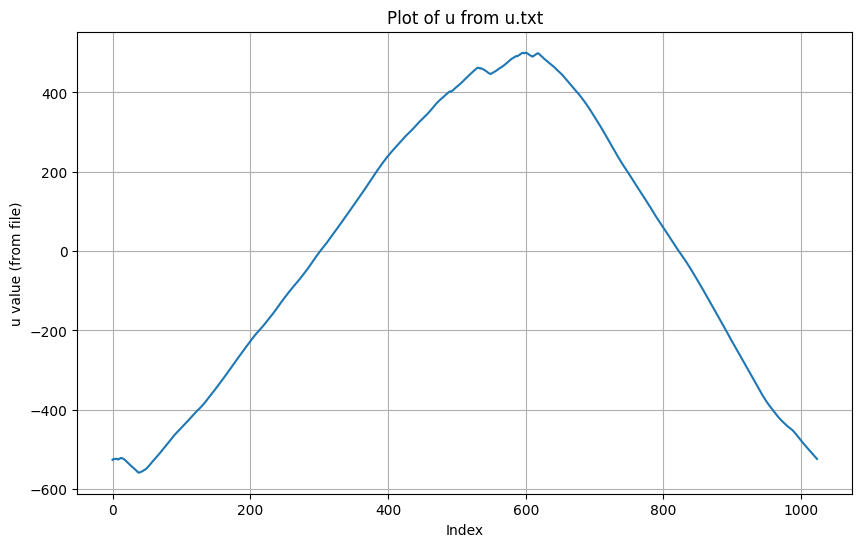

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Read u.txt
u_from_file = np.loadtxt('u.txt')

# Plot u_from_file
plt.figure(figsize=(10, 6))
plt.plot(u_from_file)
plt.xlabel('Index')
plt.ylabel('u value (from file)')
plt.title('Plot of u from u.txt')
plt.grid(True)
plt.show()

# Spectral exponent vs anharmonicity exponent $n$

In [5]:
%%bash
rm u_*.txt
for((i=0;i<50;i++))
do
  ./a.out $i
  mv u.txt u_$i.txt
done

C = 3.59396
Check periodicity (sum s): -1.86265e-08
First 10 elements of u: [-230.448, -228.916, -229.703, -230.932, -232.102, -232.818, -231.677, -230.831, -229.967, -229.24]
Done.
n=2, c=0
L=1024, Delta=1
seed=0
C = 3.59396
Check periodicity (sum s): -1.86265e-08
First 10 elements of u: [-230.448, -228.916, -229.703, -230.932, -232.102, -232.818, -231.677, -230.831, -229.967, -229.24]
Done.
n=2, c=0
L=1024, Delta=1
seed=1
C = 5.99453
Check periodicity (sum s): -2.23517e-08
First 10 elements of u: [138.166, 139.982, 141.259, 142.298, 142.962, 143.987, 145.361, 146.679, 147.421, 148.494]
Done.
n=2, c=0
L=1024, Delta=1
seed=2
C = -23.9417
Check periodicity (sum s): 0
First 10 elements of u: [171.629, 168.747, 165.719, 162.668, 159.647, 156.643, 153.688, 150.74, 147.796, 144.819]
Done.
n=2, c=0
L=1024, Delta=1
seed=3
C = -14.3706
Check periodicity (sum s): 3.72529e-09
First 10 elements of u: [396.449, 394.018, 391.392, 388.745, 386.088, 383.438, 380.844, 378.285, 375.648, 373.024]
Done.


rm: cannot remove 'u_*.txt': No such file or directory


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob

def plot_Sq(name):
  # Get all u_i.txt files
  u_files = sorted(glob.glob('u_*.txt'))
  num_configs = len(u_files)

  if num_configs == 0:
      print("No u_*.txt files found. Please make sure the bash script generated them.")
  else:
      print(f"Found {num_configs} configurations.")

      # Initialize an array to store the sum of |FFT(u)|^2
      L_u = np.loadtxt(u_files[0]).shape[0]
      sum_sq_magnitudes = np.zeros(L_u)

      for i, u_file in enumerate(u_files):
          u = np.loadtxt(u_file)

          # Subtract the mean from u before computing FFT
          u_mean_subtracted = u - np.mean(u)

          # Compute FFT of u
          fft_u = np.fft.fft(u_mean_subtracted)

          # Calculate squared magnitude: |FFT(u)|^2
          sq_magnitude = np.abs(fft_u)**2

          # Accumulate for averaging
          sum_sq_magnitudes += sq_magnitude

      # Average the squared magnitudes to get S(q)
      averaged_sq = sum_sq_magnitudes / num_configs
      with open(name, "w") as f:
        for sqdata in averaged_sq:
          print(sqdata, file=f)

      # Generate wave numbers q
      q = np.fft.fftfreq(L_u, d=1) # d=1 assumes unit spacing, 2*pi for angular frequency

      qpos = q[q>0]
      sqpos = averaged_sq[q>0]

      # Filter data for q < 0.05
      fit_indices = qpos < 0.05
      q_fit = qpos[fit_indices]
      sq_fit = sqpos[fit_indices]

      if len(q_fit) > 1:
          # Log-transform the data
          log_q = np.log(q_fit)
          log_sq = np.log(sq_fit)

          # Perform linear regression
          coeffs = np.polyfit(log_q, log_sq, 1) # 1 for linear fit
          log_A = coeffs[1] # Intercept
          B = coeffs[0]     # Slope (power law exponent)
          A = np.exp(log_A) # Convert intercept back to A

          # Generate the fit line for plotting
          q_fit_line = np.linspace(q_fit.min(), q_fit.max(), 100)
          sq_fit_line = A * q_fit_line**B

          zeta=-(B+1)/2
          plt.plot(q_fit_line, sq_fit_line, color='red', linestyle='--',
                  label=f'Power Law Fit: $S(q) \propto 1/q^{{1+2*{zeta:.2f}}}$')
          print(f"Power law fit for q < 0.05: S(q) = {A:.2e} * q^{{{B:.2f}}}")
          print("zeta=",zeta)

      plt.plot(qpos, sqpos)
      #plt.loglog(qpos, 1./qpos**(1+2*1.39))
      plt.xlabel('Frequency Index')
      plt.ylabel('Magnitude')
      plt.title('Magnitude of FFT of u')
      plt.loglog()
      plt.legend()
      plt.grid(True)
      plt.show()

      return zeta

plot_Sq('Sq.txt')



<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-84785478.py:68: SyntaxWarning: invalid escape sequence '\p'
  label=f'Power Law Fit: $S(q) \propto 1/q^{{1+2*{zeta:.2f}}}$')


Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.03e-01 * q^{-3.80}
zeta= 1.4017882601832816


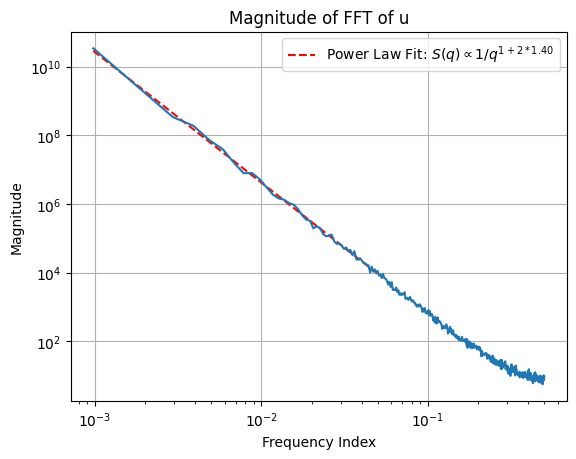

n=2, zeta=1.4017882601832816
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.07e-01 * q^{-3.69}
zeta= 1.346260472874526


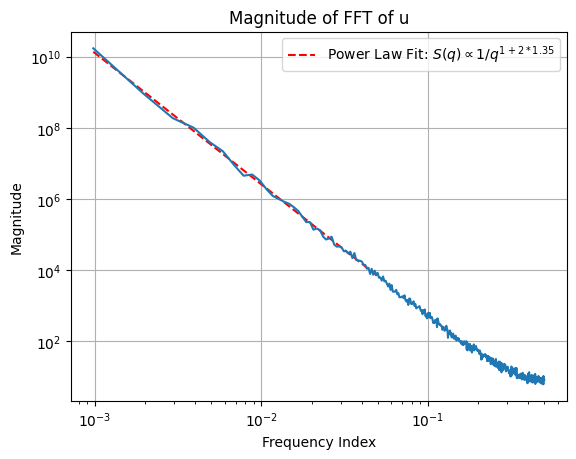

n=3, zeta=1.346260472874526
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.14e-01 * q^{-3.64}
zeta= 1.3188410502783163


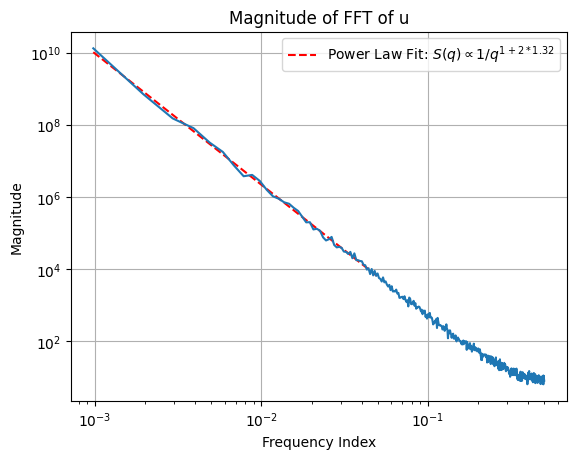

n=4, zeta=1.3188410502783163
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.21e-01 * q^{-3.61}
zeta= 1.3027786390860514


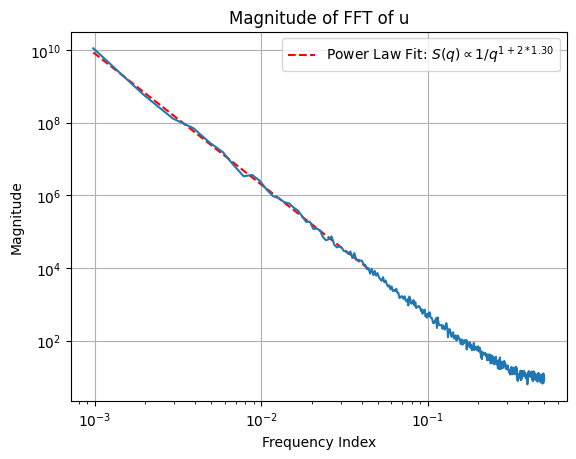

n=5, zeta=1.3027786390860514
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.26e-01 * q^{-3.58}
zeta= 1.2916894458882475


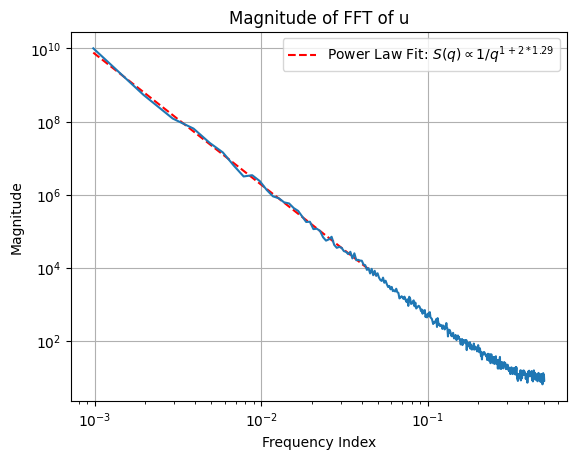

n=6, zeta=1.2916894458882475
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.30e-01 * q^{-3.57}
zeta= 1.2838230589140769


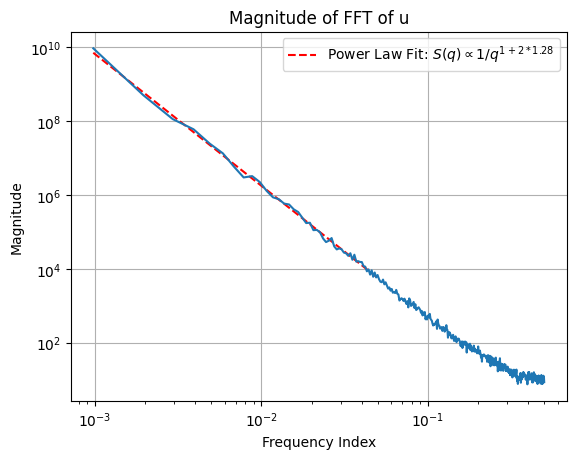

n=7, zeta=1.2838230589140769
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.34e-01 * q^{-3.56}
zeta= 1.2778426697245666


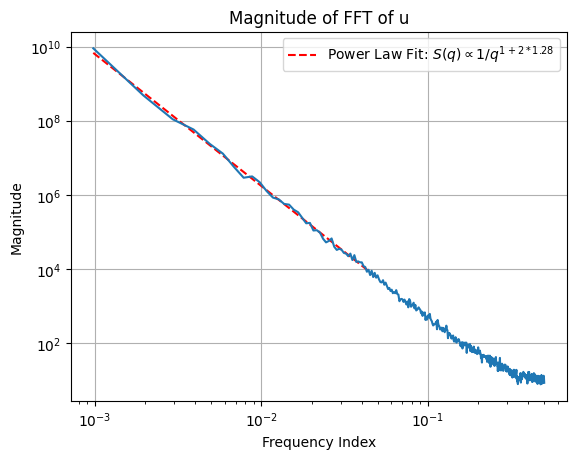

n=8, zeta=1.2778426697245666
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.37e-01 * q^{-3.55}
zeta= 1.2731560288413644


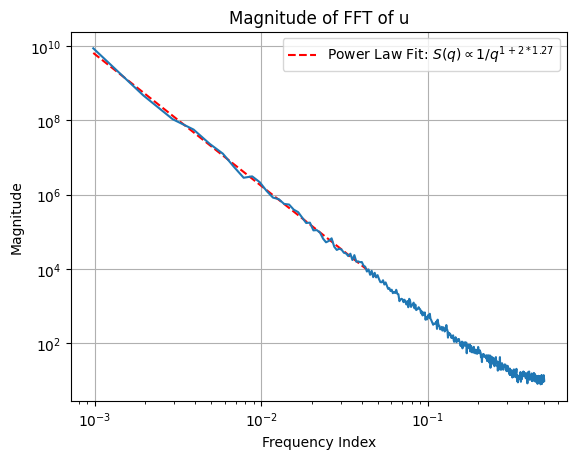

n=9, zeta=1.2731560288413644
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.39e-01 * q^{-3.54}
zeta= 1.2694802570436003


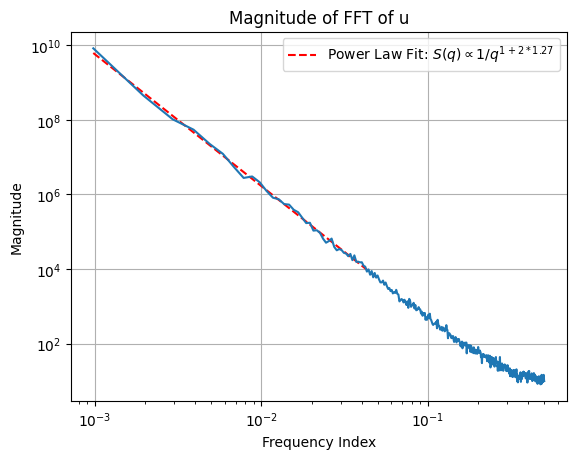

n=10, zeta=1.2694802570436003
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.41e-01 * q^{-3.53}
zeta= 1.2666444380456943


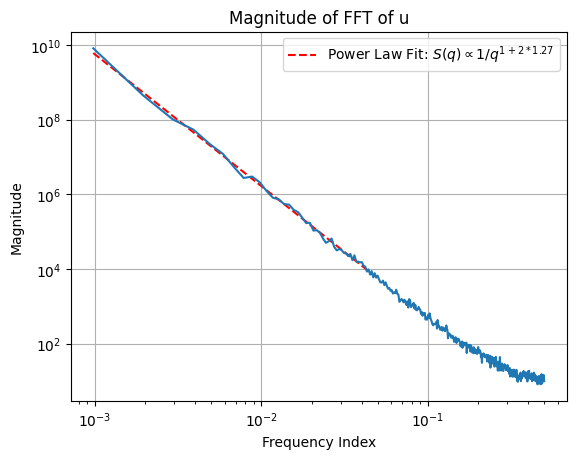

n=11, zeta=1.2666444380456943
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.43e-01 * q^{-3.53}
zeta= 1.263546969893636


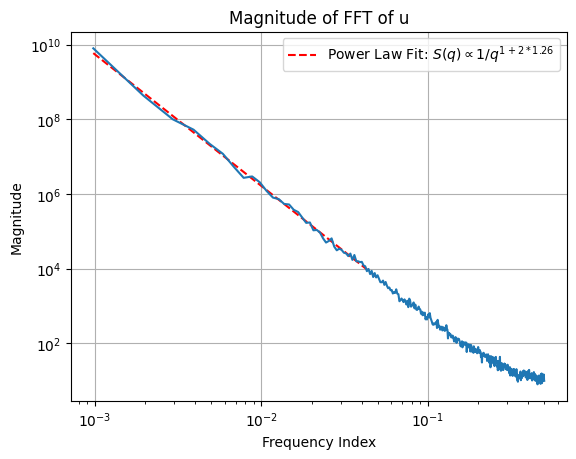

n=12, zeta=1.263546969893636
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.45e-01 * q^{-3.52}
zeta= 1.261122809587123


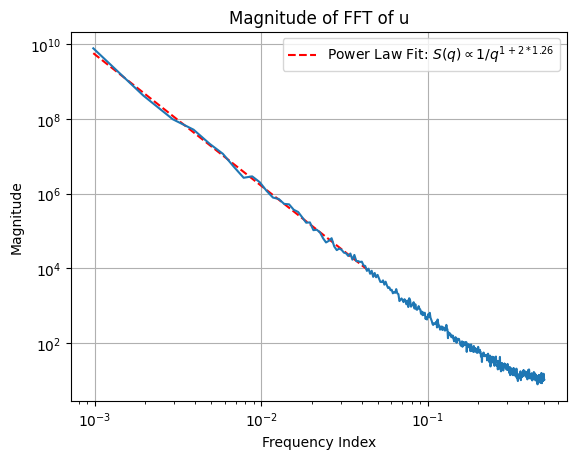

n=13, zeta=1.261122809587123
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.46e-01 * q^{-3.52}
zeta= 1.2595579451897805


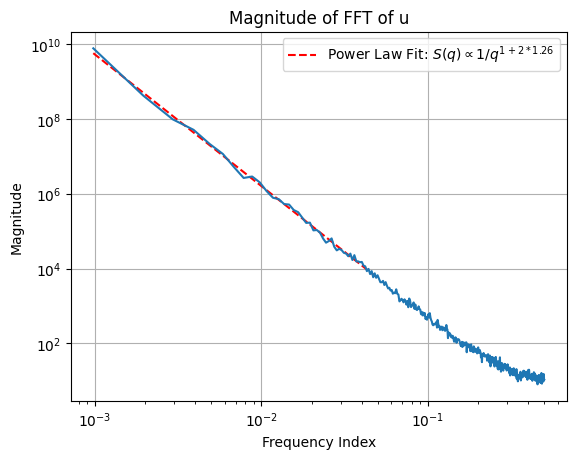

n=14, zeta=1.2595579451897805
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.47e-01 * q^{-3.52}
zeta= 1.2580453802339675


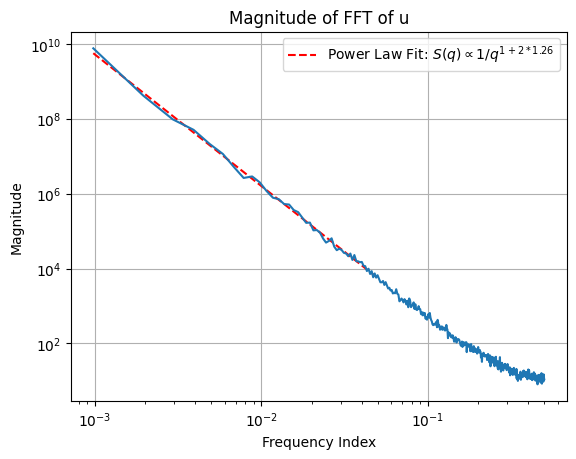

n=15, zeta=1.2580453802339675
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.49e-01 * q^{-3.51}
zeta= 1.2565043468718502


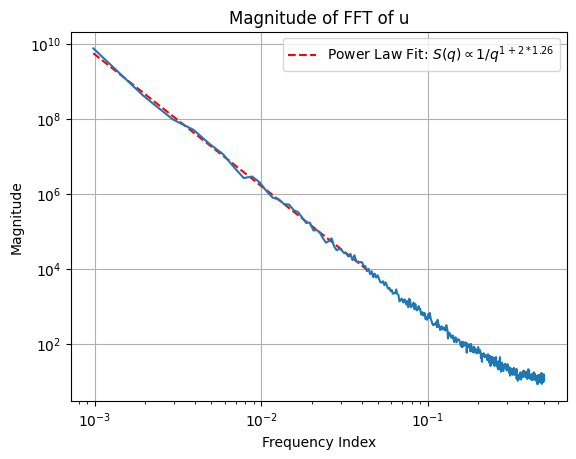

n=16, zeta=1.2565043468718502
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.49e-01 * q^{-3.51}
zeta= 1.2554500884179889


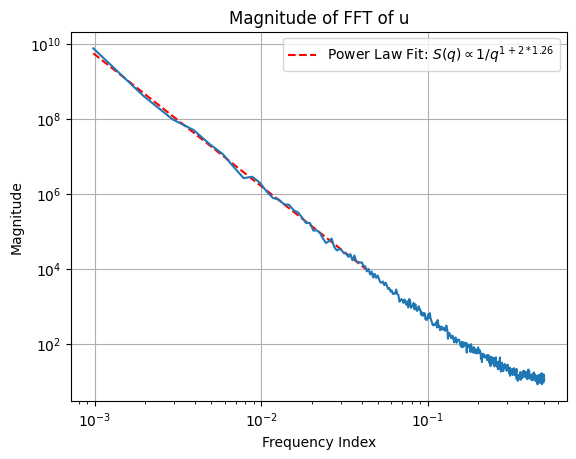

n=17, zeta=1.2554500884179889
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.50e-01 * q^{-3.51}
zeta= 1.254077663686481


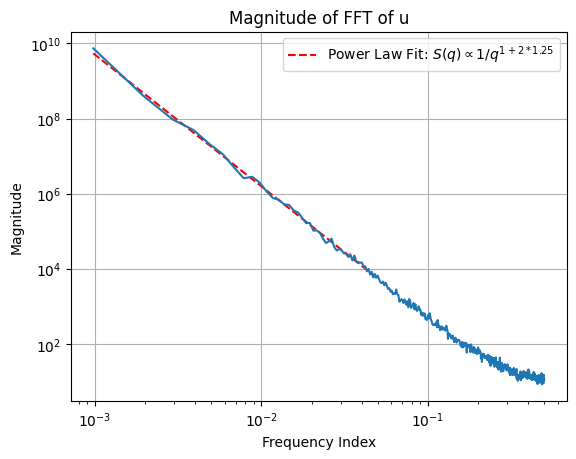

n=18, zeta=1.254077663686481
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.51e-01 * q^{-3.51}
zeta= 1.2533103400457393


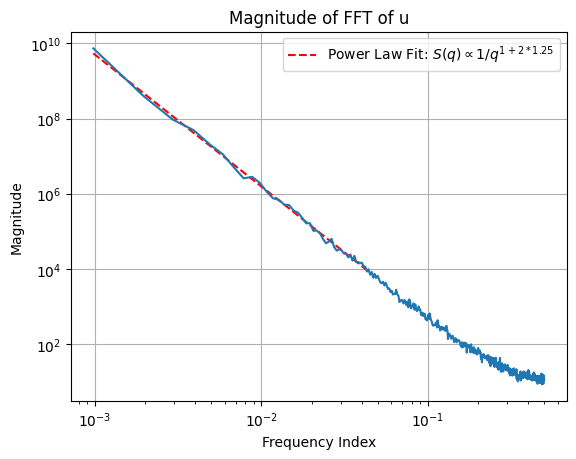

n=19, zeta=1.2533103400457393


In [7]:
import subprocess
import os

zetavsn=[]

# Primer bucle: de n=2 hasta n=9
for n in range(2, 20):
    # Compilación: se usa f-string para insertar la variable n
    # nvcc -arch=sm_75 alm.cu --extended-lambda -o a.out -DANHN=n
    compile_cmd = ["nvcc", "-arch=sm_75", "alm.cu", "--extended-lambda", "-o", "a.out", f"-DANHN={n}"]
    subprocess.run(compile_cmd, check=True)

    # Segundo bucle: de i=0 hasta i=49
    for i in range(50):
        # Ejecución: ./a.out i
        subprocess.run(["./a.out", str(i)], check=True)

        # Renombrar archivo: mv u.txt u_i.txt
        # Usamos os.rename para que sea una operación nativa y rápida
        if os.path.exists("u.txt"):
            os.rename("u.txt", f"u_{i}.txt")
    zeta = plot_Sq("Sq.txt")
    print(f"n={n}, zeta={zeta}")
    zetavsn.append(zeta)


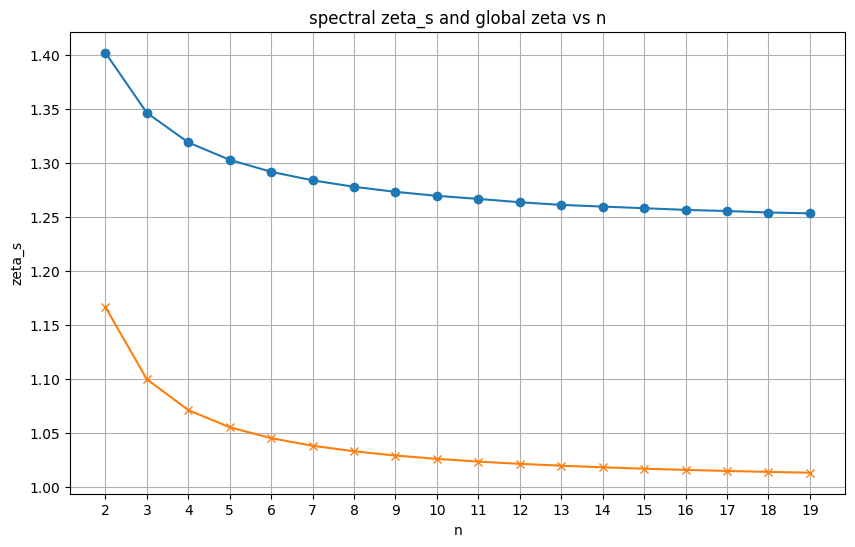

[0.23512159 0.24626047 0.24741248 0.24722308 0.2462349  0.24536152
 0.24450934 0.24374426 0.24316447 0.24283491 0.24180784 0.24112281
 0.24103943 0.240804   0.24037531 0.24029857 0.23979195 0.23979683]


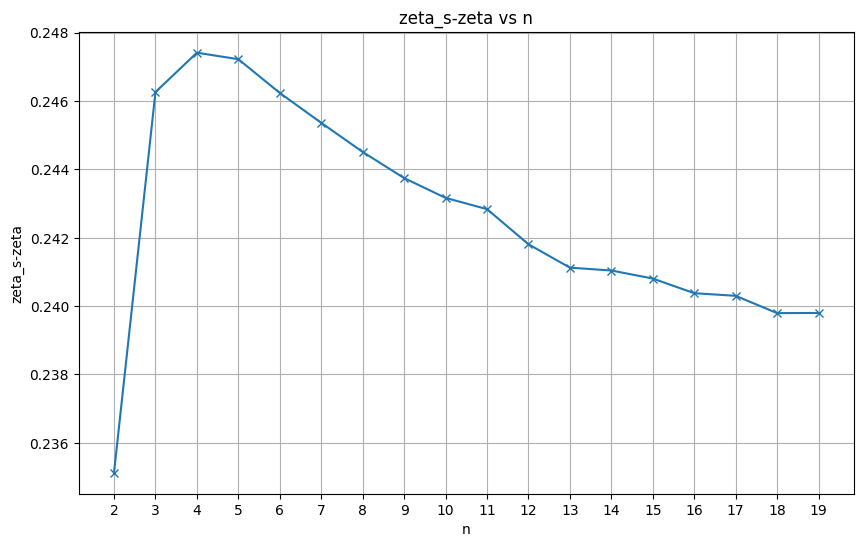

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming zetavsn is already defined and contains the zeta values
# The n values correspond to the indices + 2 (since it starts from n=2)
n_values = np.arange(2, 2 + len(zetavsn))

plt.figure(figsize=(10, 6))
plt.plot(n_values, zetavsn, marker='o', linestyle='-')
plt.plot(n_values, (4*n_values-1)/(4*n_values-2), marker='x', linestyle='-')
plt.xlabel('n')
plt.ylabel('zeta_s')
plt.title('spectral zeta_s and global zeta vs n')
plt.grid(True)
plt.xticks(n_values) # Ensure x-ticks are at integer n values
plt.show()

print(zetavsn-(4*n_values-1)/(4*n_values-2))

plt.figure(figsize=(10, 6))
plt.plot(n_values, zetavsn-(4*n_values-1)/(4*n_values-2), marker='x', linestyle='-')
plt.xlabel('n')
plt.ylabel('zeta_s-zeta')
plt.title('zeta_s-zeta vs n')
plt.grid(True)
plt.xticks(n_values) # Ensure x-ticks are at integer n values
plt.show()


# Finite Size analysis: anomalous roughnening



Found 100 configurations.
Power law fit for q < 0.05: S(q) = 1.56e-02 * q^{-3.95}
zeta= 1.4738523792380915


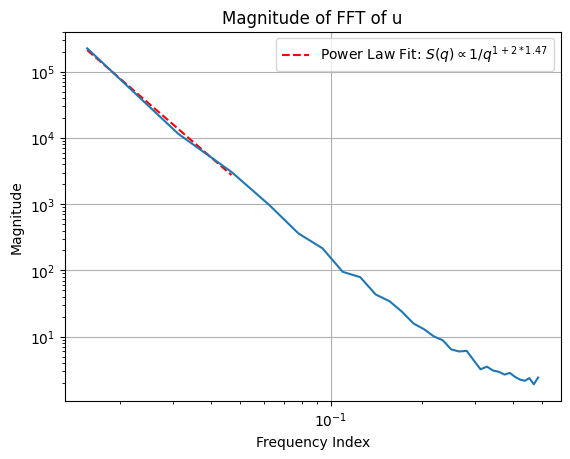

L=64, zeta=1.4738523792380915
Found 100 configurations.
Power law fit for q < 0.05: S(q) = 2.02e-02 * q^{-3.94}
zeta= 1.4679628370119


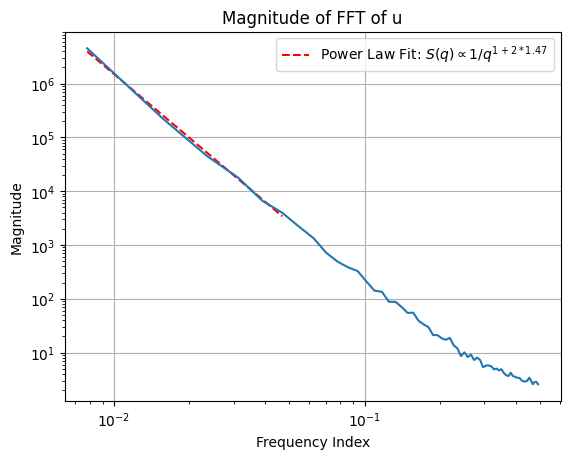

L=128, zeta=1.4679628370119
Found 100 configurations.
Power law fit for q < 0.05: S(q) = 3.13e-02 * q^{-3.90}
zeta= 1.4499364010472047


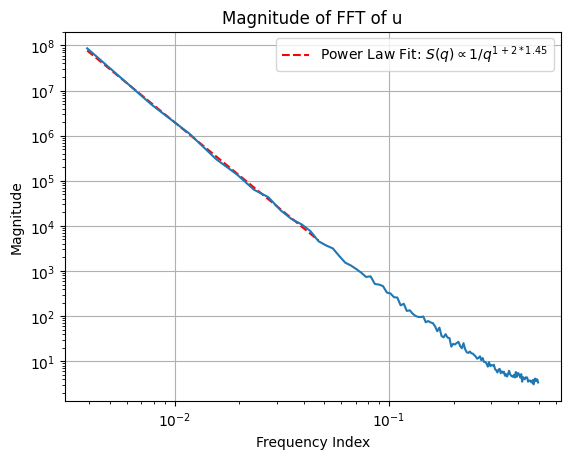

L=256, zeta=1.4499364010472047
Found 100 configurations.
Power law fit for q < 0.05: S(q) = 6.38e-02 * q^{-3.83}
zeta= 1.4142619190112498


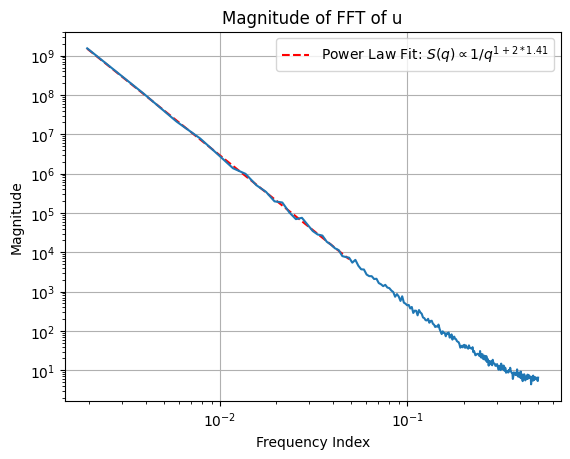

L=512, zeta=1.4142619190112498
Found 100 configurations.
Power law fit for q < 0.05: S(q) = 8.48e-02 * q^{-3.84}
zeta= 1.4191706146094796


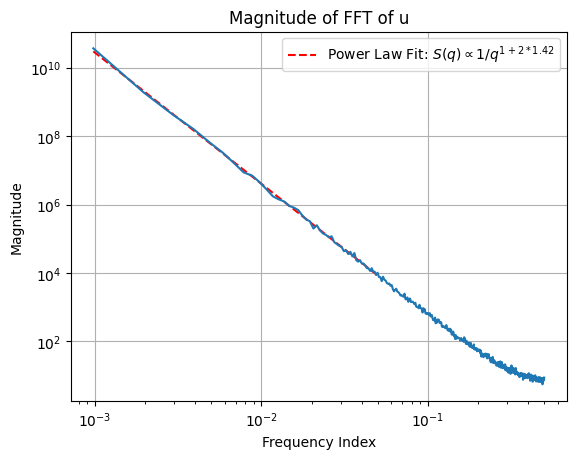

L=1024, zeta=1.4191706146094796


In [22]:
import subprocess
import os

zetavsL=[]
L_values = [64,128,256,512,1024]

# Primer bucle: de n=2 hasta n=9
for L in L_values:
    # Compilación: se usa f-string para insertar la variable n
    # nvcc -arch=sm_75 alm.cu --extended-lambda -o a.out -DANHN=n
    compile_cmd = ["nvcc", "-arch=sm_75", "alm.cu", "--extended-lambda", "-o", "a.out", f"-DSIZEL={L}",f"-DANHN=2"]
    subprocess.run(compile_cmd, check=True)

    # Segundo bucle: de i=0 hasta i=49
    for i in range(100):
        # Ejecución: ./a.out i
        subprocess.run(["./a.out", str(i)], check=True)

        # Renombrar archivo: mv u.txt u_i.txt
        # Usamos os.rename para que sea una operación nativa y rápida
        if os.path.exists("u.txt"):
            os.rename("u.txt", f"u_{i}.txt")
    zeta = plot_Sq(f"Sq_L_{L}.txt")
    print(f"L={L}, zeta={zeta}")
    zetavsL.append(zeta)


<>:37: SyntaxWarning: invalid escape sequence '\;'
<>:45: SyntaxWarning: invalid escape sequence '\;'
<>:37: SyntaxWarning: invalid escape sequence '\;'
<>:45: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipython-input-1207579753.py:37: SyntaxWarning: invalid escape sequence '\;'
  ax1.set_ylabel("$S_q \;\;q^{1+2\zeta_s}$")
/tmp/ipython-input-1207579753.py:45: SyntaxWarning: invalid escape sequence '\;'
  ax2.set_ylabel("$S_q \;\;q^{1+2\zeta_s}/L^{2(\zeta_s-\zeta)}$")


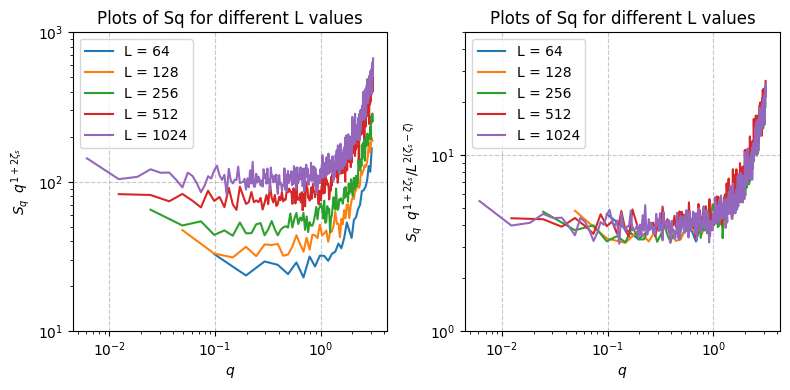

In [23]:
import matplotlib.pyplot as plt
import numpy as np


L_values = [64,128,256,512,1024]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))  # 2 rows, 1 column

#plt.figure(figsize=(10, 6))

zetas=1.402

n=2
zeta=(4*n-1)/(4*n-2)

# 2. Loop through each value of L
for L in L_values:
    filename = f"Sq_L_{L}.txt"

    try:
        # Load the data (assuming two columns: x and y)
        data = np.loadtxt(filename)
        y = data[:]
        x = np.arange(len(y))
        yp = y[x<L/2]
        xp = x[x<L/2]*2*np.pi/L
        # Plot each line with a label for the legend
        ax1.loglog(xp[1:],xp[1:]**(1+2*zetas)*yp[1:]/L**(0.00), label=f"L = {L}", marker='',linestyle='-')
        ax2.loglog(xp[1:],xp[1:]**(1+2*zetas)*yp[1:]/L**(2*(zetas-zeta)), label=f"L = {L}", marker='',linestyle='-')

    except FileNotFoundError:
        print(f"Warning: {filename} not found. Skipping...")


# 3. Add labels, legend, and grid
ax1.set_xlabel("$q$")
ax1.set_ylabel("$S_q \;\;q^{1+2\zeta_s}$")
ax1.set_title("Plots of Sq for different L values")
ax1.legend()  # Shows the 'L = ...' labels
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(10,1e3)

# 3. Add labels, legend, and grid
ax2.set_xlabel("$q$")
ax2.set_ylabel("$S_q \;\;q^{1+2\zeta_s}/L^{2(\zeta_s-\zeta)}$")
ax2.set_title("Plots of Sq for different L values")
ax2.legend()  # Shows the 'L = ...' labels
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_ylim(1,1e2/2.)

plt.tight_layout()

# 4. Show the final result
plt.show()

indicating *anomalous superroughening*

$$S_q \propto L^{2(\zeta_s-\zeta)} q^{-(1+2\zeta_s)}$$



# Python Code

Check periodicity (sum s): -4.547473508864641e-13
Mean displacement: 4.263256414560601e-14
Check periodicity (sum s): -5.684341886080802e-14
Mean displacement: 1.4210854715202004e-14
Check periodicity (sum s): 2.2168933355715126e-11
Mean displacement: -2.842170943040401e-14
Check periodicity (sum s): 5.684341886080802e-14
Mean displacement: 7.105427357601002e-15
Check periodicity (sum s): -8.958522812463343e-11
Mean displacement: 0.0
Check periodicity (sum s): 1.1368683772161603e-13
Mean displacement: 7.105427357601002e-15
Check periodicity (sum s): -1.1368683772161603e-13
Mean displacement: -1.4210854715202004e-14
Check periodicity (sum s): -1.1368683772161603e-13
Mean displacement: -1.4210854715202004e-14
Check periodicity (sum s): 1.5916157281026244e-12
Mean displacement: -2.842170943040401e-14
Check periodicity (sum s): -2.842170943040401e-14
Mean displacement: 7.105427357601002e-15
Check periodicity (sum s): -1.1368683772161603e-13
Mean displacement: -1.4210854715202004e-14
Check 

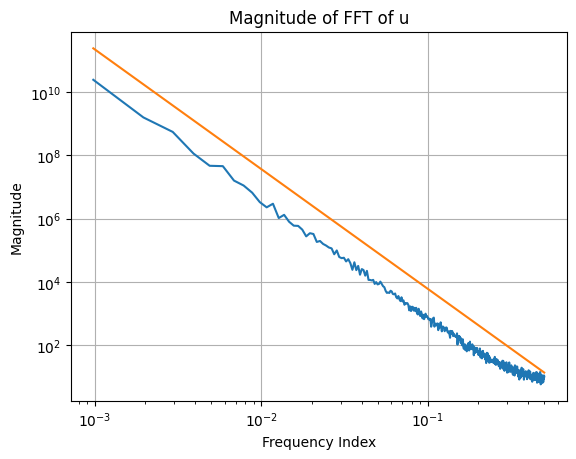

In [11]:
import numpy as np
from scipy.optimize import brentq


def generate_sample(L,Delta,n,c, seed):
  np.random.seed(seed)
  # -----------------------------
  # Disorder
  # -----------------------------
  f = np.random.normal(0.0, np.sqrt(Delta), size=L)
  f -= f.mean()

  # cumulative disorder force
  F = np.concatenate([[0.0], np.cumsum(f[:-1])])

  # -----------------------------
  # Constitutive inversion
  # -----------------------------
  def slope_from_stress(sigma):
      """
      Solve: c*s + sign(s)*|s|^{2n-1} = sigma
      Unique solution due to convexity
      """
      if c == 0:
          return np.sign(sigma) * abs(sigma)**(1.0/(2*n-1))

      def eq(s):
          return c*s + np.sign(s)*abs(s)**(2*n-1) - sigma

      # bracket safely
      smax = max(1.0, abs(sigma)**(1.0/(2*n-1)) + 1.0)
      return brentq(eq, -smax, smax)

  # vectorized wrapper
  vec_slope = np.vectorize(slope_from_stress)

  # -----------------------------
  # Constraint: zero total slope
  # -----------------------------
  def total_slope(C):
      sigma = F + C
      s = vec_slope(sigma)
      return np.sum(s)

  # find C
  C = brentq(total_slope, -100.0, 100.0)

  # -----------------------------
  # Build solution
  # -----------------------------
  sigma = F + C
  s = vec_slope(sigma)

  u = np.zeros(L)
  u[1:] = np.cumsum(s[:-1])

  # remove arbitrary offset
  u -= u.mean()

  # -----------------------------
  # Diagnostics
  # -----------------------------
  print("Check periodicity (sum s):", np.sum(s))
  print("Mean displacement:", u.mean())

  return u


# -----------------------------
# Parameters
# -----------------------------
L = 1024          # system size
Delta = 1.0       # disorder variance
n = 2             # nonlinear exponent (n >= 1)
c = 0             # harmonic elasticity strength
seed = 12

sq = np.zeros(L)
nsamples=30
for seed in range(nsamples):
  u=generate_sample(L,Delta,n,c, seed)
  sq += np.abs(np.fft.fft(u))**2
  #print(u)

sq /= nsamples
q = np.fft.fftfreq(L, d=1)  # d=1 assumes unit spacing, 2*pi for angular frequency
#q = np.fft.fftshift(q) # Shift zero frequency to the center

qpos = q[q>0]
sqpos = sq[q>0]

plt.loglog(qpos, sqpos)
plt.loglog(qpos, 1./qpos**(1+2*1.39))
plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.title('Magnitude of FFT of u')
plt.grid(True)
plt.show()


In [12]:
print(u)

[-60.5061124  -58.3452135  -56.21619968 ... -66.78224891 -64.65040654
 -62.6453791 ]


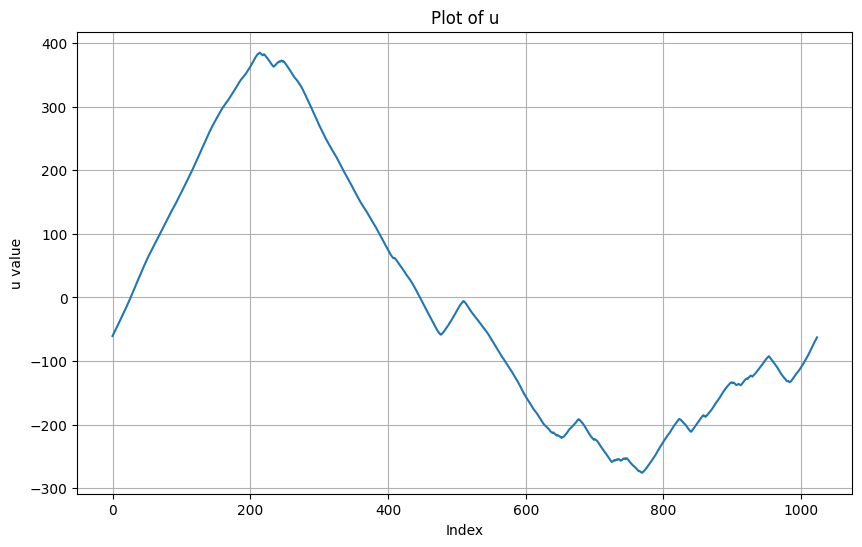

In [13]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(u)
plt.xlabel('Index')
plt.ylabel('u value')
plt.title('Plot of u')
plt.grid(True)
plt.show()